## DEGIRO ANALYZER 

REF https://pypi.org/project/degiroapi/

- estratto dati 
- calcolato vs storico . 
- tolto riga di creazione passw .. si fa cosi . keyring.set_password("degiro", "fabertel", quimettilapassword)
- allineato currency, aggiunto target,calcolato delta vs target
- fixed historyz (usato ID ,perche ci sono piu ID per ogni ISIN a seconda del mercato) 
- normalizzato valori confrontato con current price e prezz odi acquisto, plot per idnetificare i best buys

FARE

- script per fare azioni ! 
- togliere lines d icreazione passw

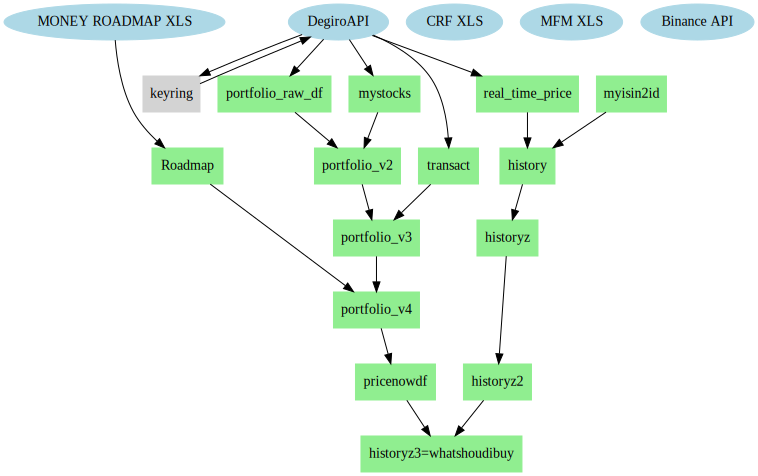

In [1]:
from graphviz import Digraph
u = Digraph(comment='Money',node_attr={'color': 'lightblue', 'style': 'filled'})

with u.subgraph() as s:
    s.attr(rank='same')
    s.node('MONEY ROADMAP XLS')
    s.node('DegiroAPI')
    s.node('CRF XLS')
    s.node('MFM XLS')
    s.node('Binance API')

u.attr('node', shape='box', style='filled', color='lightgrey')
u.node('keyring')
u.attr('node', shape='box', style='filled', color='lightgreen')
u.edge('DegiroAPI','keyring')
u.edge('keyring','DegiroAPI')
u.edge('MONEY ROADMAP XLS','Roadmap')
u.edge('DegiroAPI','portfolio_raw_df')
u.edge('DegiroAPI','transact')
u.edge('DegiroAPI','mystocks')
u.edge('DegiroAPI','real_time_price')
u.edge('portfolio_raw_df','portfolio_v2')
u.edge('mystocks','portfolio_v2')
u.edge('portfolio_v2','portfolio_v3')
u.edge('transact','portfolio_v3')
u.edge('Roadmap','portfolio_v4')
u.edge('portfolio_v3','portfolio_v4')
u.edge('myisin2id','history')
u.edge('real_time_price','history')
u.edge('history','historyz')

u.edge('portfolio_v4','pricenowdf')
u.edge('historyz','historyz2')
u.edge('historyz2','historyz3=whatshoudibuy')
u.edge('pricenowdf','historyz3=whatshoudibuy')

u

## IMPORTS

In [2]:
import keyring
import pandas as pd
import degiroapi
from degiroapi.product import Product
from degiroapi.order import Order
from degiroapi.utils import pretty_json
import numpy as np
from forex_python.converter import CurrencyRates

pd.set_option('display.max_columns', None)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## LOAD DATA

In [3]:
degiro = degiroapi.DeGiro()
passw = keyring.get_password("degiro", "fabertel")
degiro.login("fabertel", passw)

cashfunds = degiro.getdata(degiroapi.Data.Type.CASHFUNDS)
for data in cashfunds:
    print(data)

portfolio_raw = degiro.getdata(degiroapi.Data.Type.PORTFOLIO, True)

portfolio_raw_df = pd.DataFrame(portfolio_raw)
myportfolio = portfolio_raw_df['id'].tolist()

from datetime import datetime, timedelta
trans = degiro.transactions(datetime(2020, 1, 1), datetime.now())
transact = pd.DataFrame(trans)

mystocks = pd.DataFrame(columns = ['id', 'name', 'isin', 'symbol', 'contractSize', 'productType',
       'productTypeId', 'tradable', 'category', 'currency', 'exchangeId',
       'onlyEodPrices', 'orderTimeTypes', 'buyOrderTypes', 'sellOrderTypes',
       'productBitTypes', 'closePrice', 'closePriceDate', 'feedQuality',
       'orderBookDepth', 'vwdIdentifierType', 'vwdId', 'qualitySwitchable',
       'qualitySwitchFree', 'vwdModuleId']) 

for i in (myportfolio):
    info = degiro.product_info(i)
    tmp = pd.DataFrame.from_dict(info, orient='index').transpose()
    mystocks = mystocks.append(tmp)
    
mystocks=mystocks[['id', 'name','isin', 'symbol', 'productType', 'category', 'currency', 'closePrice', 'closePriceDate']]

ROADMAP = pd.read_excel ('moneyroadmap.xls')
ROADMAP = ROADMAP[(ROADMAP.GOAL.notnull())]

# degiro.logout()

{'data': {'id': 1363902,
  'intAccount': 111016885,
  'loggedInPersonId': 1366698,
  'clientRole': 'basic',
  'effectiveClientRole': 'basic',
  'contractType': 'PRIVATE',
  'username': 'fabertel',
  'displayName': 'Fabio Bertellotti',
  'email': 'fabio.bertellotti@gmail.com',
  'firstContact': {'firstName': 'Fabio',
   'lastName': 'Bertellotti',
   'displayName': 'Fabio Bertellotti',
   'nationality': 'IT',
   'gender': 'MALE',
   'dateOfBirth': '1975-04-06',
   'placeOfBirth': 'Siena',
   'countryOfBirth': 'IT'},
  'address': {'streetAddress': 'via F.Caracciolo',
   'streetAddressNumber': '22',
   'zip': '50133',
   'city': 'Firenze',
   'country': 'IT'},
  'cellphoneNumber': '+393892882181',
  'locale': 'it_IT',
  'language': 'it',
  'culture': 'IT',
  'bankAccount': {'bankAccountId': 1484866,
   'bic': 'BCITITMMXXX',
   'iban': 'IT51X0306902911000000001960',
   'status': 'VERIFIED'},
  'memberCode': 'AA7042FD',
  'isWithdrawalAvailable': True,
  'isAllocationAvailable': False,
  'is

EUR 2189.44


## CREATE PORTFOLIO

In [4]:
portfolio_v2 = pd.merge(portfolio_raw_df,mystocks,how="left")
portfolio_v2 = portfolio_v2 [['isin', 'symbol','name','value', 'size', 'price','breakEvenPrice','productType', 'category', 'currency','closePrice', 'closePriceDate','id', 'positionType']]
portfolio_v2 = portfolio_v2.sort_values(["productType", "value"], ascending = (True, False))

transactrecap = transact.groupby(['productId']).agg({"price": [np.min,np.mean,np.max],"totalPlusFeeInBaseCurrency": [np.sum],"id": [np.size],"date":[np.min,np.max]}).reset_index()
transactrecap.columns = transactrecap.columns.get_level_values(0) # flatten multiindex df 
transactrecap=transactrecap.set_axis (['productId', 'pricemin', 'pricemean', 'pricemax', 'totalPlusFeeInEur','trans_cnt', 'datemin', 'datemax'], axis=1, inplace=False)
portfolio_v2['id'] = portfolio_v2['id'].astype(np.float64)

portfolio_v3=pd.merge(portfolio_v2,transactrecap,how="left",left_on="id",right_on="productId")
portfolio_v3 = portfolio_v3 [['isin', 'symbol', 'name', 'value','totalPlusFeeInEur', 'size', 'price', 'productType', 'category', 'currency', 'pricemin', 'pricemean', 'pricemax',  'trans_cnt','datemin', 'datemax','breakEvenPrice','closePrice', 'closePriceDate', 'id', 'positionType', 'productId']]
portfolio_v3= portfolio_v3.set_axis (['isin', 'symbol', 'name', 'valuenowCURR','spentEUR', 'size', 'pricenow', 'productType', 'category', 'currency', 'pricebuymin', 'pricebuymean', 'pricebuymax',  'trans_cnt','datemin', 'datemax','breakEvenPrice','closePrice', 'closePriceDate', 'id', 'positionType', 'productId'], axis=1, inplace=False)

TOTACCOUNT=portfolio_v3['valuenowCURR'].sum()
INVESTED = portfolio_v3[(portfolio_v3.symbol!='FSUCEURCSH')]['valuenowCURR'].sum()
NOTINVESTED = portfolio_v3[(portfolio_v3.symbol=='FSUCEURCSH')]['valuenowCURR'].sum()

for index, row in portfolio_v3.iterrows():
    portfolio_v3.at[index, 'investedPerc'] = row['valuenowCURR']/TOTACCOUNT
    portfolio_v3.at[index, 'spentEUR'] = -row['spentEUR']
    portfolio_v3.at[index, 'Delta'] = row['valuenowCURR']+row['spentEUR']
    if (row['spentEUR']!=0):
        portfolio_v3.at[index, 'DeltaPerc'] = -(row['valuenowCURR']+row['spentEUR'])/row['spentEUR']
        
colsneworder = ['isin', 'symbol', 'name', 'valuenowCURR','spentEUR','Delta', 'DeltaPerc','investedPerc','size', 'pricenow', 'productType', 'category', 'currency', 'pricebuymin', 'pricebuymean', 'pricebuymax',  'trans_cnt','datemin', 'datemax','breakEvenPrice','closePrice', 'closePriceDate', 'id', 'positionType', 'productId']
portfolio_v3 = portfolio_v3.reindex(columns= colsneworder)
portfolio_v3 = portfolio_v3.sort_values(["productType", "Delta"], ascending = (True, False))

# INVESTED = portfolio_v3[(portfolio_v3.symbol!='FSUCEURCSH')]['spentEUR'].sum()
# NOTINVESTED = portfolio_v2[(portfolio_v2.symbol=='FSUCEURCSH')]['value'].sum()
# DELTA = portfolio_v3[(portfolio_v3.symbol!='FSUCEURCSH')]['Delta'].sum()
# investedPerccc = portfolio_v3['investedPerc'].sum()
# DELTAPERC = (DELTA/INVESTED)
# TOTACCOUNT,INVESTED,NOTINVESTED,DELTA,DELTAPERC,investedPerccc

portfolio_v4 = pd.merge(portfolio_v3,ROADMAP, how = "left" , left_on="isin" , right_on="ISIN")
currentrates = CurrencyRates()

for index, row in portfolio_v4.iterrows():
    portfolio_v4.at[index, 'GOALinvestment'] = TOTACCOUNT*row['GOAL']
    portfolio_v4.at[index, 'vsGOAL'] = row['valuenowCURR']-(TOTACCOUNT*row['GOAL'])
    portfolio_v4.at[index, 'vsEURrate'] = currentrates.get_rate(row['currency'], 'EUR')  
    portfolio_v4.at[index, 'valuenowEUR'] = (currentrates.get_rate(row['currency'], 'EUR'))*row['valuenowCURR']

# FORMAT TABLE .. crea dizionario di formattazioni formatdict poi lo applica in portfolio_v4.style.format(formatdict)
formatdict = {}
col2formatPERC = ['DeltaPerc','investedPerc','GOAL','GOALvsPIANO']
col2formatFLOAT2 = ['valuenowCURR','valuenowEUR','spentEUR','Delta', 'GOALinvestment', 'vsGOAL','size', 'pricenow', 'vsEURrate', 'pricebuymin', 'pricebuymean', 'pricebuymax', 'trans_cnt','breakEvenPrice','closePrice']
for j in col2formatFLOAT2: formatdict[j] = "{:.2f}"
for j in col2formatPERC: formatdict[j] = "{:.0%}"
portfolio_v4.style.format(formatdict)    


,isin,symbol,name,valuenowCURR,spentEUR,Delta,DeltaPerc,investedPerc,size,pricenow,productType,category,currency,pricebuymin,pricebuymean,pricebuymax,trans_cnt,datemin,datemax,breakEvenPrice,closePrice,closePriceDate,id,positionType,productId,PIANO,SHORT,ISIN,GOALvsPIANO,GOAL,GOALinvestment,vsGOAL,vsEURrate,valuenowEUR
0,NL0010661914,FSUCEURCSH,EUR Cash Fund FundShare,2189.44,nan,nan,nan%,12%,2231.85,0.98,CASH,D,EUR,nan,nan,nan,nan,nan,nan,0.98,0.98,2021-01-07,5173554.000000,CASH,nan,CASH,FSUCEURCSH,NL0010661914,5%,5%,923.41,1266.04,1.00,2189.44
1,IE00B4L5Y983,SWDA,ISHSIII-CORE MSCI WORLD U.ETF,7028.80,6299.90,728.90,12%,38%,115.00,61.12,ETF,H,EUR,53.00,54.96,55.95,4.00,2020-10-20T09:04:29+02:00,2020-10-30T15:48:57+01:00,54.70,61.12,2021-01-08,4622784.000000,PRODUCT,4622784.000000,BASE,SWDA,IE00B4L5Y983,60%,42%,7756.61,-727.81,1.00,7028.80
2,IE00BF0M2Z96,BATT,L&G BATTERY VALUE-CHAIN UCITS ETF,1351.72,904.67,447.05,49%,7%,94.00,14.38,ETF,H,EUR,9.60,9.60,9.60,1.00,2020-10-28T09:04:45+01:00,2020-10-28T09:04:45+01:00,9.60,14.38,2021-01-08,14418200.000000,PRODUCT,14418200.000000,LONGRUN,BATT,IE00BF0M2Z96,20%,6%,1108.09,243.63,1.00,1351.72
3,IE00BYZK4552,RBOT,ISHARES AUTOMAT & ROBOTICS UCITS ETF ACC,1091.88,909.47,182.41,20%,6%,108.00,10.11,ETF,H,EUR,8.40,8.40,8.40,1.00,2020-10-28T09:13:11+01:00,2020-10-28T09:13:11+01:00,8.40,10.11,2021-01-09,12063898.000000,PRODUCT,12063898.000000,LONGRUN,RBOT,IE00BYZK4552,20%,6%,1108.09,-16.21,1.00,1091.88
4,IE00BYWQWR46,ESP0,VANECK ETFS-V.V.VID.GAM.+ESPTS,1083.30,943.87,139.43,15%,6%,30.00,36.11,ETF,I,EUR,31.30,31.59,31.89,2.00,2020-10-09T13:57:25+02:00,2020-10-30T15:16:41+01:00,31.32,36.11,2021-01-08,16143345.000000,PRODUCT,16143345.000000,LONGRUN,ESPO,IE00BYWQWR46,20%,6%,1108.09,-24.79,1.00,1083.30
5,IE00B74DQ490,HYLD,ISHARES GLO HIGH YLD CORP UCITS ETF DIST,1553.63,1510.65,42.98,3%,8%,19.00,81.77,ETF,F,EUR,79.00,79.25,79.60,4.00,2020-10-19T14:06:34+02:00,2020-10-26T09:08:40+01:00,79.17,81.77,2021-01-08,7496799.000000,PRODUCT,7496799.000000,BASE,HYLD,IE00B74DQ490,15%,10%,1939.15,-385.52,1.00,1553.63
6,IE00BD49RB39,EYLD,WisdomTree EUR Agg Bd Enhanced Yield ETF EUR Acc,1483.30,1477.64,5.66,0%,8%,26.00,57.05,ETF,F,EUR,56.50,56.60,56.70,2.00,2020-10-20T16:56:43+02:00,2020-12-02T09:04:05+01:00,56.66,57.05,2021-01-09,14902751.000000,PRODUCT,14902751.000000,BASE,EYLD,IE00BD49RB39,15%,10%,1939.15,-455.85,1.00,1483.30
7,IE00BYZK4669,AGED,iShares Ageing Population UCITS ETF USD (Acc),24.24,23.03,1.21,5%,0%,4.00,7.41,ETF,H,USD,6.20,6.20,6.20,1.00,2020-10-09T14:09:21+02:00,2020-10-09T14:09:21+02:00,6.20,7.41,2021-01-08,11853221.000000,PRODUCT,11853221.000000,LONGRUN,AGED,IE00BYZK4669,20%,6%,1108.09,-1083.84,0.82,19.79
8,IE00B579F325,SGLD,Invesco Physical Gold ETC,735.15,749.62,-14.47,-2%,4%,5.00,147.03,ETF,A,EUR,147.00,152.19,157.39,2.00,2020-10-14T17:18:40+02:00,2020-12-03T10:27:23+01:00,149.08,147.03,2021-01-09,5396380.000000,PRODUCT,5396380.000000,BASE,SGLD,IE00B579F325,10%,7%,1292.77,-557.62,1.00,735.15
9,US92556V1061,VTRS,Viatris,104.76,-0.00,104.76,nan%,1%,7.00,18.30,STOCK,B,USD,0.00,0.00,0.00,1.00,2020-11-17T00:00:00+01:00,2020-11-17T00:00:00+01:00,0.00,18.30,2021-01-08,18584838.000000,PRODUCT,18584838.000000,nan,nan,nan,nan%,nan%,nan,nan,0.82,85.52


In [5]:
portfolio_v4.to_excel('portfolio_v4.xls')

## HISTORICAL TRENDS

In [6]:

myisin2id_data = [['IE00B4L5Y983','4622784'],
['IE00BF0M2Z96','14418200'],
['IE00BYZK4552','12063898'],
['IE00BYWQWR46','16143345'],
['IE00B74DQ490','7496799'],
['IE00BD49RB39','14902751'],
['IE00BYZK4669','11853221'],
['IE00B579F325','5396380'],
['US92556V1061','18584838'],
['US7170811035','332062']]

myisin2id = pd.DataFrame(myisin2id_data, columns = ['isin', 'id']) 

myIDs = myisin2id['id'].tolist()


In [7]:

history = pd.DataFrame(columns = ['isin','alfa','cumulativeVolume','market','name','windowHighPrice','windowHighTime','windowLowPrice','windowLowTime','Type','lastPrice'])

for i in (myIDs):

    realprice = degiro.real_time_price(i, degiroapi.Interval.Type.One_Week)
    realprice[0]['data']['Type'] = 'One_Week'    # add label to dict 
    tmp = pd.DataFrame.from_dict(realprice[0]['data'], orient='index').transpose()
    colsneworder_v5 = ['isin','alfa','cumulativeVolume','market','name','windowHighPrice','windowHighTime','windowLowPrice','windowLowTime','Type','lastPrice']
    tmp = tmp.reindex(columns= colsneworder_v5)
    history=history.append(tmp)

    realprice = degiro.real_time_price(i, degiroapi.Interval.Type.One_Month)
    realprice[0]['data']['Type'] = 'One_Month'
    tmp = pd.DataFrame.from_dict(realprice[0]['data'], orient='index').transpose()
    colsneworder_v5 = ['isin','alfa','cumulativeVolume','market','name','windowHighPrice','windowHighTime','windowLowPrice','windowLowTime','Type','lastPrice']
    tmp = tmp.reindex(columns= colsneworder_v5)
    history=history.append(tmp)

    realprice = degiro.real_time_price(i, degiroapi.Interval.Type.One_Year)
    realprice[0]['data']['Type'] = 'One_Year'
    tmp = pd.DataFrame.from_dict(realprice[0]['data'], orient='index').transpose()
    colsneworder_v5 = ['isin','alfa','cumulativeVolume','market','name','windowHighPrice','windowHighTime','windowLowPrice','windowLowTime','Type','lastPrice']
    tmp = tmp.reindex(columns= colsneworder_v5)
    history=history.append(tmp)


In [8]:
historyz = pd.DataFrame([y.values.ravel() for x , y in history.groupby(np.arange(len(history))//3)])

historyz.columns= ['isin', 'alfa', 'cumulativeVolume', 'market', 'name', 'windowHighPrice','windowHighTime', 'windowLowPrice', 'windowLowTime', 'Type','lastPrice',
 'isin1', 'alfa1', 'cumulativeVolume1', 'market1', 'name1','windowHighPrice1','windowHighTime1', 'windowLowPrice1', 'windowLowTime1', 'Type1','lastPrice1',
'isin2', 'alfa2', 'cumulativeVolume2', 'market2', 'name2', 'windowHighPrice2','windowHighTime2', 'windowLowPrice2', 'windowLowTime2', 'Type2','lastPrice2']

historyz = historyz.drop(['isin1', 'alfa1', 'cumulativeVolume1', 'market1', 'name1','lastPrice1'] ,  axis='columns')
historyz = historyz.drop(['isin2', 'alfa2', 'cumulativeVolume2', 'market2', 'name2','lastPrice2'] ,  axis='columns')

historyz= historyz.set_axis (['isin', 'alfa', 'cumVol', 'market', 'name', 
'1W_H','1W_HT', '1W_L', '1W_LT', 'Type','lastPrice',
'1M_H','1M_HT', '1M_L', '1M_LT', 'Type',
'1Y_H','1Y_HT', '1Y_L', '1Y_LT', 'Type'], axis=1, inplace=False)

for index, row in historyz.iterrows():
    historyz.at[index, 'vs_1W'] = (row['lastPrice']-row['1W_L'])/(row['1W_H']-row['1W_L'])
    historyz.at[index, 'vs_1M'] = (row['lastPrice']-row['1M_L'])/(row['1M_H']-row['1M_L'])
    historyz.at[index, 'vs_1Y'] = (row['lastPrice']-row['1Y_L'])/(row['1Y_H']-row['1Y_L'])

# historyz.to_excel('historyz.xls')

,name_x,isin,PIANO,SHORT,GOAL,GOALinvestment,vsGOAL,valuenowEUR,pricenow_EUR,QUOTES2BUY,TOT2BUY,QUOTES2BUY2,TOT2BUY2,NEWvaluenowEUR,NEWvsGOAL,NEWvsGOALperc,NEWGOAL
0,Pfizer Inc,US7170811035,0,0,0%,0.00,0.000000,1487.26,30.31,0,0.00,0,0.00,1487.26,1487.26,nan%,9%
1,INVESCO PHYSICAL GOLD ETC,IE00B579F325,BASE,SGLD,7%,1292.77,-557.618461,735.15,147.03,3,441.09,3,441.09,1176.24,-116.53,-9%,7%
2,WISDOMTREE EUR AG BO ENH UCITS ETF EUR A,IE00BD49RB39,BASE,EYLD,10%,1939.15,-455.852691,1483.30,57.05,7,399.35,7,399.35,1882.65,-56.50,-3%,11%
3,iShares Core MSCI World UCITS ETF,IE00B4L5Y983,BASE,SWDA,42%,7756.61,-727.810765,7028.80,61.12,11,672.32,7,427.84,7456.64,-299.97,-4%,43%
4,L&G BATTERY VALUE-CHAIN UCITS ETF,IE00BF0M2Z96,LONGRUN,BATT,6%,1108.09,243.632748,1351.72,14.38,-17,-244.46,0,0.00,1351.72,243.63,22%,8%
5,VANECK ETFS-V.V.VID.GAM.+ESPTS,IE00BYWQWR46,LONGRUN,ESPO,6%,1108.09,-24.787252,1083.30,36.11,0,0.00,0,0.00,1083.30,-24.79,-2%,6%
6,ISHARES GLO HIGH YLD CORP UCITS ETF DIST,IE00B74DQ490,BASE,HYLD,10%,1939.15,-385.522691,1553.63,81.77,4,327.08,0,0.00,1553.63,-385.52,-20%,9%
7,iSh Ageing Pop USD Acc,IE00BYZK4669,LONGRUN,AGED,6%,1108.09,-1083.844389,19.79,6.05,179,1082.91,0,0.00,19.79,-1088.30,-98%,0%
8,ISHARES AUTOMAT & ROBOTICS UCITS ETF ACC,IE00BYZK4552,LONGRUN,RBOT,6%,1108.09,-16.207252,1091.88,10.11,1,10.11,0,0.00,1091.88,-16.21,-1%,6%
9,Viatris,US92556V1061,0,0,0%,0.00,0.000000,85.52,14.94,0,0.00,0,0.00,85.52,85.52,nan%,0%


18,110
15,920
2,189
1,268
17,189


<Figure size 360x576 with 0 Axes>

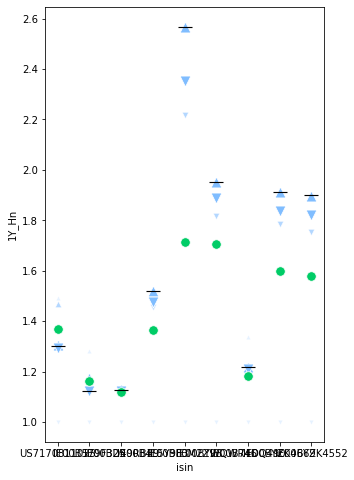

In [11]:
import seaborn as sns 

import matplotlib.pyplot as plt

INVESTED = portfolio_v4[(portfolio_v4.symbol!='FSUCEURCSH')]['valuenowEUR'].sum()
NOTINVESTED = portfolio_v4[(portfolio_v4.symbol=='FSUCEURCSH')]['valuenowEUR'].sum()
TOTCAPITAL=INVESTED+NOTINVESTED
TOINVEST = NOTINVESTED-(TOTCAPITAL*(5/100))

pricenowdf= portfolio_v4.copy()
pricenowdf= pricenowdf[['isin','pricenow','pricebuymean','pricebuymin','pricebuymax']]
historyz2 = historyz.copy()
historyz2 = historyz2 [['cumVol','market','name','isin','1Y_L','1M_L', '1W_L','1W_H', '1M_H', '1Y_H']]
historyz3 = pd.merge(historyz2,pricenowdf)

# NORMALIZZA E IDENTIFICA BEST BUY
historyz3['1Y_Ln'] = historyz3['1Y_L']/historyz3['1Y_L']
historyz3['1M_Ln'] = historyz3['1M_L']/historyz3['1Y_L']
historyz3['1W_Ln'] = historyz3['1W_L']/historyz3['1Y_L']
historyz3['1Y_Hn'] = historyz3['1Y_H']/historyz3['1Y_L']
historyz3['1M_Hn'] = historyz3['1M_H']/historyz3['1Y_L']
historyz3['1W_Hn'] = historyz3['1W_H']/historyz3['1Y_L']
historyz3['pricenown'] = historyz3['pricenow']/historyz3['1Y_L']
historyz3['pricebuymeann'] = historyz3['pricebuymean']/historyz3['1Y_L']
historyz3['pricebuyminn'] = historyz3['pricebuymin']/historyz3['1Y_L']
historyz3['pricebuymaxn'] = historyz3['pricebuymax']/historyz3['1Y_L']
historyz3['bestbuy'] = (historyz3['pricenow']-historyz3['1M_L'])/(historyz3['1M_H']-historyz3['1M_L'])
historyz3=historyz3.sort_values(by=('bestbuy'), ascending=True)

tobuyfinal =pd.merge(historyz3,portfolio_v4,how="left",on="isin")
tobuyfinal['pricenow_EUR']=tobuyfinal['pricenow_x']*tobuyfinal['vsEURrate']
tobuyfinal['QUOTES2BUY']=round(-(tobuyfinal['vsGOAL']/tobuyfinal['pricenow_EUR'])-0.5)
tobuyfinal['TOT2BUY']=tobuyfinal['QUOTES2BUY']*tobuyfinal['pricenow_EUR']

for i, row in tobuyfinal.iterrows():
    if ((row['QUOTES2BUY']>0) & (TOINVEST>0)):
        if (row['TOT2BUY']<TOINVEST):
            QUOTES2BUY2val=row['QUOTES2BUY']
        else : 
            QUOTES2BUY2val = round((TOINVEST/row['pricenow_EUR'])-0.5)
        TOINVEST=TOINVEST-row['TOT2BUY']
        tobuyfinal.at[i,'QUOTES2BUY2']= QUOTES2BUY2val
        tobuyfinal.at[i,'TOT2BUY2']=QUOTES2BUY2val*row['pricenow_EUR']

TOT2BUY2SUM = tobuyfinal['TOT2BUY2'].sum()    
NEWINVESTED = TOT2BUY2SUM+INVESTED

tobuyfinal=tobuyfinal.replace(np.nan, 0)
for i, row in tobuyfinal.iterrows():
    NEWvaluenowEURval=row['valuenowEUR']+(row['QUOTES2BUY2']*row['pricenow_EUR'])
    tobuyfinal.at[i,'NEWvaluenowEUR']=NEWvaluenowEURval
    tobuyfinal.at[i,'NEWvsGOAL']=NEWvaluenowEURval-row['GOALinvestment']
    tobuyfinal.at[i,'NEWGOAL']=(NEWvaluenowEURval/NEWINVESTED)
    if (row['GOALinvestment'] > 0 ):
        tobuyfinal.at[i,'NEWvsGOALperc']=(NEWvaluenowEURval-row['GOALinvestment'])/row['GOALinvestment']            

tobuyfinal = tobuyfinal[['name_x', 'isin','PIANO', 'SHORT','GOAL', 'GOALinvestment', 'vsGOAL', 'valuenowEUR','pricenow_EUR', 'QUOTES2BUY', 'TOT2BUY', 'QUOTES2BUY2', 'TOT2BUY2', 'NEWvaluenowEUR', 'NEWvsGOAL','NEWvsGOALperc','NEWGOAL']]

# FORMAT TABLE .. crea dizionario di formattazioni formatdict poi lo applica in portfolio_v4.style.format(formatdict)
formatdict2 = {}
col2formatPERC = ['GOAL','NEWvsGOALperc','NEWGOAL']
col2formatINT = ['QUOTES2BUY','QUOTES2BUY2']
col2formatFLOAT2 = ['GOALinvestment','valuenowEUR','pricenow_EUR', 'TOT2BUY', 'TOT2BUY2', 'NEWvaluenowEUR', 'NEWvsGOAL']
for j in col2formatPERC: formatdict2[j] = "{:.0%}"
for j in col2formatINT: formatdict2[j] = "{:.0f}"
for j in col2formatFLOAT2: formatdict2[j] = "{:.2f}"
tobuyfinal.style.format(formatdict2)    

a = TOTCAPITAL,INVESTED,NOTINVESTED,TOT2BUY2SUM,NEWINVESTED
for i in range(len(a)):
    print('{:,.0f}'.format(a[i]))
    
# PLOT
plt.figure(figsize=(5, 8))
g=sns.scatterplot(data=historyz3, x="isin", y="1Y_Hn",color="#e6f2ff", marker = '^', s=20)
g=sns.scatterplot(data=historyz3, x="isin", y="1Y_Ln",color="#e6f2ff", marker = 'v', s=20)
g=sns.scatterplot(data=historyz3, x="isin", y="1M_Hn",color="#b3d7ff", marker = '^', s=40)
g=sns.scatterplot(data=historyz3, x="isin", y="1M_Ln",color="#b3d7ff", marker = 'v', s=40)
g=sns.scatterplot(data=historyz3, x="isin", y="1W_Hn",color="#80bdff", marker = '^', s=120)
g=sns.scatterplot(data=historyz3, x="isin", y="1W_Ln",color="#80bdff", marker = 'v', s=120)
g=sns.scatterplot(data=historyz3, x="isin", y="pricebuymeann",color="#00cc66" , marker = 'o',s=90)
g=sns.scatterplot(data=historyz3, x="isin", y="pricenown",color="black" , marker = '_',s=200)
#g.set_xticklabels(historyz['name'].tolist(),rotation=90)


In [13]:

tmp = tobuyfinal[tobuyfinal['TOT2BUY2'] > 0]
tmp = tmp [['name_x', 'isin','QUOTES2BUY', 'TOT2BUY','pricenow_EUR']]

tmp2=pd.merge(tmp,myisin2id,how="left",on="isin")
tmp2

# degiro.buyorder(Order.Type.LIMIT, Product(products[0]).id, 3, 1, 30)

# degiro.buyorder(Order.Type.LIMIT, id , 3, quantity, limit)
degiro.buyorder(Order.Type.LIMIT, 4622784, 3, 1, 10)

,name_x,isin,QUOTES2BUY,TOT2BUY,pricenow_EUR,id
0,INVESCO PHYSICAL GOLD ETC,IE00B579F325,3.0,441.09,147.03,5396380
1,WISDOMTREE EUR AG BO ENH UCITS ETF EUR A,IE00BD49RB39,7.0,399.35,57.05,14902751
2,iShares Core MSCI World UCITS ETF,IE00B4L5Y983,11.0,672.32,61.12,4622784


Exception: Could not place order Response: {"errors":[{"text":"order.error.accidentalDownTime"}]}

In [ ]:
degiro = degiroapi.DeGiro()
passw = keyring.get_password("degiro", "fabertel")
degiro.login("fabertel", passw)


# degiro.buyorder(Order.Type.LIMIT, 4622784, 3, 1, 10)
# degiro.buyorder(Order.Type.MARKET, 4622784, 3, 1)

In [ ]:


# DELTA = portfolio_v3[(portfolio_v3.symbol!='FSUCEURCSH')]['Delta'].sum()
# investedPerccc = portfolio_v3['investedPerc'].sum()
# DELTAPERC = (DELTA/INVESTED)
# TOTACCOUNT,INVESTED,NOTINVESTED,DELTA,DELTAPERC,investedPerccc

In [ ]:
INVESTED = portfolio_v5[(portfolio_v5.symbol!='FSUCEURCSH')]['valuenowEUR'].sum()
NOTINVESTED = portfolio_v5[(portfolio_v5.symbol=='FSUCEURCSH')]['valuenowEUR'].sum()
TOTCAPITAL=INVESTED+NOTINVESTED
TOINVEST = NOTINVESTED-(TOTCAPITAL*(5/100))

a = TOTCAPITAL,INVESTED,NOTINVESTED,TOINVEST
for i in range(len(a)):
    print('{:,.0f}'.format(a[i]))
    
portfolio_v5=pd.merge(portfolio_v4,myisin2id,how="left",on="isin")
tobuyfinal =pd.merge(historyz3,portfolio_v5,how="left",on="isin")



In [ ]:
tobuyfinal

## ORDINI

In [ ]:
from datetime import datetime, timedelta

orders = degiro.orders(datetime.now() - timedelta(days=90), datetime.now())
orders_log = pd.DataFrame(orders)
orders_log

## BACKUP

In [ ]:
# getting realtime and historical data from a stock
products = degiro.search_products('PFE')
products

In [ ]:
i=0
for index, row in FINAL.iterrows():
    FINAL.at[i, 'GAMEDATE2'] = datetime.datetime.strptime(row['GAMEDATE'], '%d/%m/%Y')
    FINAL.at[i, 'GAMETEAMS'] = row['TEAMH']+row['TEAMA']
    FINAL.at[i, 'WINNER_ID'] = round(row['resultRF'])
    if (round(row['resultRF'])==0):    #1 TEAMH , 0 TEAMA
        win=row['TEAMA']
    else:

In [ ]:
# TEST 


products = degiro.search_products('US92556V1061', 5)
dsa = pd.DataFrame(products)
dsa
dsa[(dsa['isin']=='IE00BYZK4552')&(dsa['exchangeId']=='608')]

realprice = degiro.real_time_price(5396380, degiroapi.Interval.Type.One_Month)
# realprice = degiro.real_time_price(Product(products[0]).id, degiroapi.Interval.Type.One_Day)
dsa2 = pd.DataFrame.from_dict(realprice[0]['data'], orient='index').transpose()  
dsa2

products = degiro.search_products('SGLD')
print(products)
dsa = pd.DataFrame(products)
dsa

# # Interval can be set to One_Day, One_Week, One_Month, Three_Months, Six_Months, One_Year, Three_Years, Five_Years, Max
# realprice = degiro.real_time_price(Product(products[0]).id, degiroapi.Interval.Type.One_Day)

# # reatime data
# print(realprice[0]['data']['lastPrice'])
# print(pretty_json(realprice[0]['data']))

history[(history['isin']=='IE00B579F325')]


In [ ]:
sp5symbols = []
products = degiro.get_stock_list(14, 846)
for product in products:
    sp5symbols.append(Product(product).symbol)
    
